<a href="https://colab.research.google.com/github/RohitKumar2705/GANS/blob/main/PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras as K


In [2]:
def upscale_layer(layer, upscale_factor):
	'''
	Upscales layer (tensor) by the factor (int) where
      the tensor is [group, height, width, channels]
	'''
	height, width = layer.get_shape()[1:3]
	size = (upscale_factor * height, upscale_factor * width)
	upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
	return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
	'''
	Smoothly merges in a layer based on a threshold value alpha.
	This function assumes: that all layers are already in RGB.
	This is the function for the Generator.
	:list_of_layers	:	items should be tensors ordered by size
	:alpha 			: 	float \in (0,1)
	'''
	# Hint!
  # If you are using pure Tensorflow rather than Keras, always remember scope
	last_fully_trained_layer = list_of_layers[-2]
	# now we have the originally trained layer
	last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

	# this is the newly added layer not yet fully trained
	larger_native_layer = list_of_layers[-1]

	# This makes sure we can run the merging code
	assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

	# This code block should take advantage of broadcasting
	new_layer = (1-alpha) * upscaled_layer + larger_native_layer * alpha

	return new_layer

<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-398/1335730499.py:17: SyntaxWarning: invalid escape sequence '\i'
  :alpha 			: 	float \in (0,1)


In [3]:
def minibatch_std_layer(layer,group_size = 4):
  '''
  Will calculate minibatch standard deviation for a layer.
  Will do so under a pre-specified tf-scope with Keras.
  Assumes layer is a float32 data type. Else needs validation/casting.
  NOTE: there is a more efficient way to do this in Keras, but just for
  clarity and alignment with major implementations (for understanding)
  this was done more explicitly. Try this as an exercise.
  '''
  # Hint!
  # If you are using pure Tensorflow rather than Keras, always remember scope
  # minibatch group must be divisible by (or <=) group_size
  group_size = K.backend.minimum(group_size, tf.shape(layer)[0])

  # just getting some shape information so that we can use
  # them as shorthand as well as to ensure defaults
  shape = list(K.int_shape(input))
  shape[0] = tf.shape(input)[0]

  # Reshaping so that we operate on the level of the minibatch
  # in this code we assume the layer to be:
  # [Group (G), Minibatch (M), Width (W), Height (H) , Channel (C)]
  # but be careful different implementations use the Theano specific
  # order instead
  minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))

  # Center the mean over the group [M, W, H, C]
  minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)
  # Calculate the variance of the group [M, W, H, C]
  minibatch = tf.reduce_mean(K.backend.square(minibatch), axis = 0)
  # Calculate the standard deviation over the group [M,W,H,C]
  minibatch = K.backend.square(minibatch + 1e8)
  # Take average over feature maps and pixels [M,1,1,1]
  minibatch = tf.reduce_mean(minibatch, axis=[1,2,4], keepdims=True)
  # Add as a layer for each group and pixels
  minibatch = K.backend.tile(minibatch, [group_size, 1, shape[2], shape[3]])
  # Append as a new feature map
  return K.backend.concatenate([layer, minibatch], axis=1)

In [4]:
def equalize_learning_rate(shape, gain, fan_in=None):
    '''
    This adjusts the weights of every layer by the constant from
    He's initializer so that we adjust for the variance in the dynamic range
    in different features
    shape   :   shape of tensor (layer): these are the dimensions of each layer.
    For example, [4,4,48,3]. In this case,
        [kernel_size, kernel_size, number_of_filters, feature_maps].
        But this will depend slightly on your implementation.
    gain    :   typically sqrt(2)
    fan_in  :   adjustment for the number of incoming connections as per Xavier's / He's initialization
    '''
    # Default value is product of all the shape dimension minus the feature maps dim -- this gives us the number of incoming connections per neuron
    if fan_in is None: fan_in = np.prod(shape[:-1])
    # This uses He's initialization constant (He et al, 2015)
    std = gain / K.sqrt(fan_in)
    # creates a constant out of the adjustment
    wscale = K.constant(std, name='wscale', dtype=np.float32)
    # gets values for weights and then uses broadcasting to apply the adjustment
    adjusted_weights = K.get_value('layer', shape=shape,
            initializer=tf.initializers.random_normal()) * wscale
    return adjusted_weights

In [6]:
# pixel wise feature normalization
def pixelwise_feat_norm(inputs, **kwargs):
	'''
	Uses pixelwise feature normalization as proposed by
	Krizhevsky et at. 2012. Returns the input normalized
	:inputs 	: 	Keras / TF Layers
	'''
	normalization_constant = K.backend.sqrt(K.backend.mean(
					inputs**2, axis=-1, keepdims=True) + 1.0e-8)
	return inputs / normalization_constant

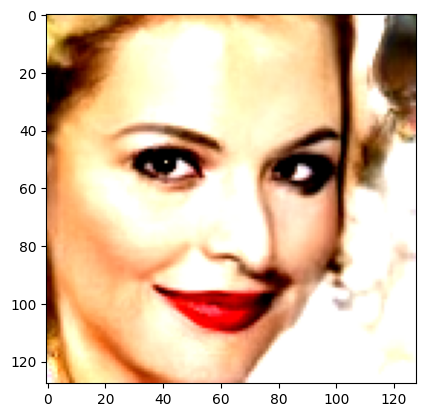

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# Load the module using hub.load() which returns an AutoTrackable object.
module = hub.load("https://tfhub.dev/google/progan-128/1")
latent_dim = 512

# change the seed
latent_vector = tf.random.normal([1, latent_dim], seed=1337)

# Explicitly call the 'serving_default' signature of the loaded module.
# This is a robust way to invoke the primary function of a SavedModel.
interpolated_images = module.signatures['serving_default'](latent_vector)['output_0']

# In TF2.x, eager execution is default, so no tf.Session() is needed.
# Just convert the tensor to a NumPy array for matplotlib.
image_out = interpolated_images.numpy()

plt.imshow(image_out.reshape(128,128,3))
plt.show()

In [11]:
# Install the latest Tensorflow version.
!pip install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip install tensorflow-hub
# Install imageio for creating animations.
!pip install imageio

In [13]:
import imageio
import matplotlib.pyplot as plt
import time
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from IPython import display
from skimage import transform

latent_dim = 512

def interpolated_hypersphere(v1,v2,num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)


# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))


# Simple way to display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)


# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

# Removed: tf.logging.set_verbosity(tf.logging.ERROR) as it's deprecated in TF2.x

Available module signatures: KeysView(_SignatureMap({'default': <ConcreteFunction (latent_vector: TensorSpec(shape=(None, 512), dtype=tf.float32, name='latent_vector')) -> Dict[['default', TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)]] at 0x7E3103F13EF0>}))


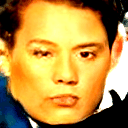

In [18]:
def interpolate_between_vectors():
  # In TF2.x, eager execution is default, so tf.Graph and tf.Session are not needed.
  module = hub.load("https://tfhub.dev/google/progan-128/1")

  # --- Diagnostic line added here to inspect available signatures ---
  print(f"Available module signatures: {module.signatures.keys()}")
  # -----------------------------------------------------------------

  # Change the seed to get different random vectors.
  v1 = tf.random.normal([latent_dim], seed=3)
  v2 = tf.random.normal([latent_dim], seed=1)

  # Creates a tensor with 50 steps of interpolation between v1 and v2.
  vectors = interpolated_hypersphere(v1, v2, 25)

  # Uses module to generate images from the latent space.
  # Access the 'default' signature for model execution
  interpolated_images = module.signatures['default'](vectors)['default']

  # In TF2.x, just convert the tensor to a NumPy array for matplotlib.
  interpolated_images_out = interpolated_images.numpy()

  animate(interpolated_images_out)

interpolate_between_vectors()

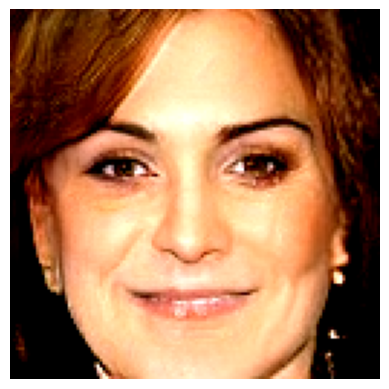

In [21]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  # In TF2.x, eager execution is default, so tf.Graph and tf.Session are not needed.
  module = hub.load("https://tfhub.dev/google/progan-128/1")
  vector = tf.random.normal([1, latent_dim], seed=4)

  # Access the 'default' signature for model execution and its 'default' output
  images = module.signatures['default'](vector)['default']

  # In TF2.x, just convert the tensor to a NumPy array.
  image_out = images.numpy()[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[uploaded.keys()[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

In [23]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []

  # In TF2.x, eager execution is default, so tf.Graph and tf.Session are not needed.
  module = hub.load("https://tfhub.dev/google/progan-128/1")

  # Define latent vector as a trainable tf.Variable for optimization in eager mode
  initial_vector = tf.random.normal([1, latent_dim], seed=5)
  vector = tf.Variable(initial_vector, name="vector")

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.3)

  # Convert target_image (numpy array) to a TensorFlow tensor
  target_image_tensor = tf.convert_to_tensor(target_image[:,:,:3], dtype=tf.float32)

  for step in range(num_optimization_steps):
    with tf.GradientTape() as tape:
      # Call the module's 'default' signature and access its 'default' output
      image = module.signatures['default'](vector)['default']

      # Calculate target_image_difference using TF2.x tensor operations
      target_image_difference = tf.reduce_sum(tf.abs(image[0] - target_image_tensor))

      # Regularizer remains largely the same
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer

    # Apply gradients
    gradients = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(gradients, [vector]))

    images.append(image.numpy()[0]) # Convert tensor to numpy for appending
    losses.append(loss.numpy()) # Convert tensor to numpy for appending
    print(f"Step {step}: Loss = {loss.numpy():.4f}") # Print formatted loss

  return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)

Step 0: Loss = 19396.9199
Step 1: Loss = 8211.0596
Step 2: Loss = 6409.8320
Step 3: Loss = 6230.1992
Step 4: Loss = 6045.0688
Step 5: Loss = 5854.6953
Step 6: Loss = 5673.9502
Step 7: Loss = 5529.5269
Step 8: Loss = 5415.3755
Step 9: Loss = 5327.7383
Step 10: Loss = 5255.4639
Step 11: Loss = 5196.4668
Step 12: Loss = 5147.5840
Step 13: Loss = 5097.5200
Step 14: Loss = 5039.1694
Step 15: Loss = 4973.4204
Step 16: Loss = 4910.2925
Step 17: Loss = 4852.2222
Step 18: Loss = 4801.7485
Step 19: Loss = 4756.2944
Step 20: Loss = 4713.1284
Step 21: Loss = 4668.7925
Step 22: Loss = 4628.0483
Step 23: Loss = 4587.6260
Step 24: Loss = 4544.8735
Step 25: Loss = 4499.4468
Step 26: Loss = 4458.3027
Step 27: Loss = 4418.2163
Step 28: Loss = 4378.8105
Step 29: Loss = 4338.1245
Step 30: Loss = 4300.5244
Step 31: Loss = 4265.0850
Step 32: Loss = 4232.6675
Step 33: Loss = 4201.7529
Step 34: Loss = 4169.6035
Step 35: Loss = 4138.9014
Step 36: Loss = 4114.2002
Step 37: Loss = 4096.8623
Step 38: Loss = 4081.

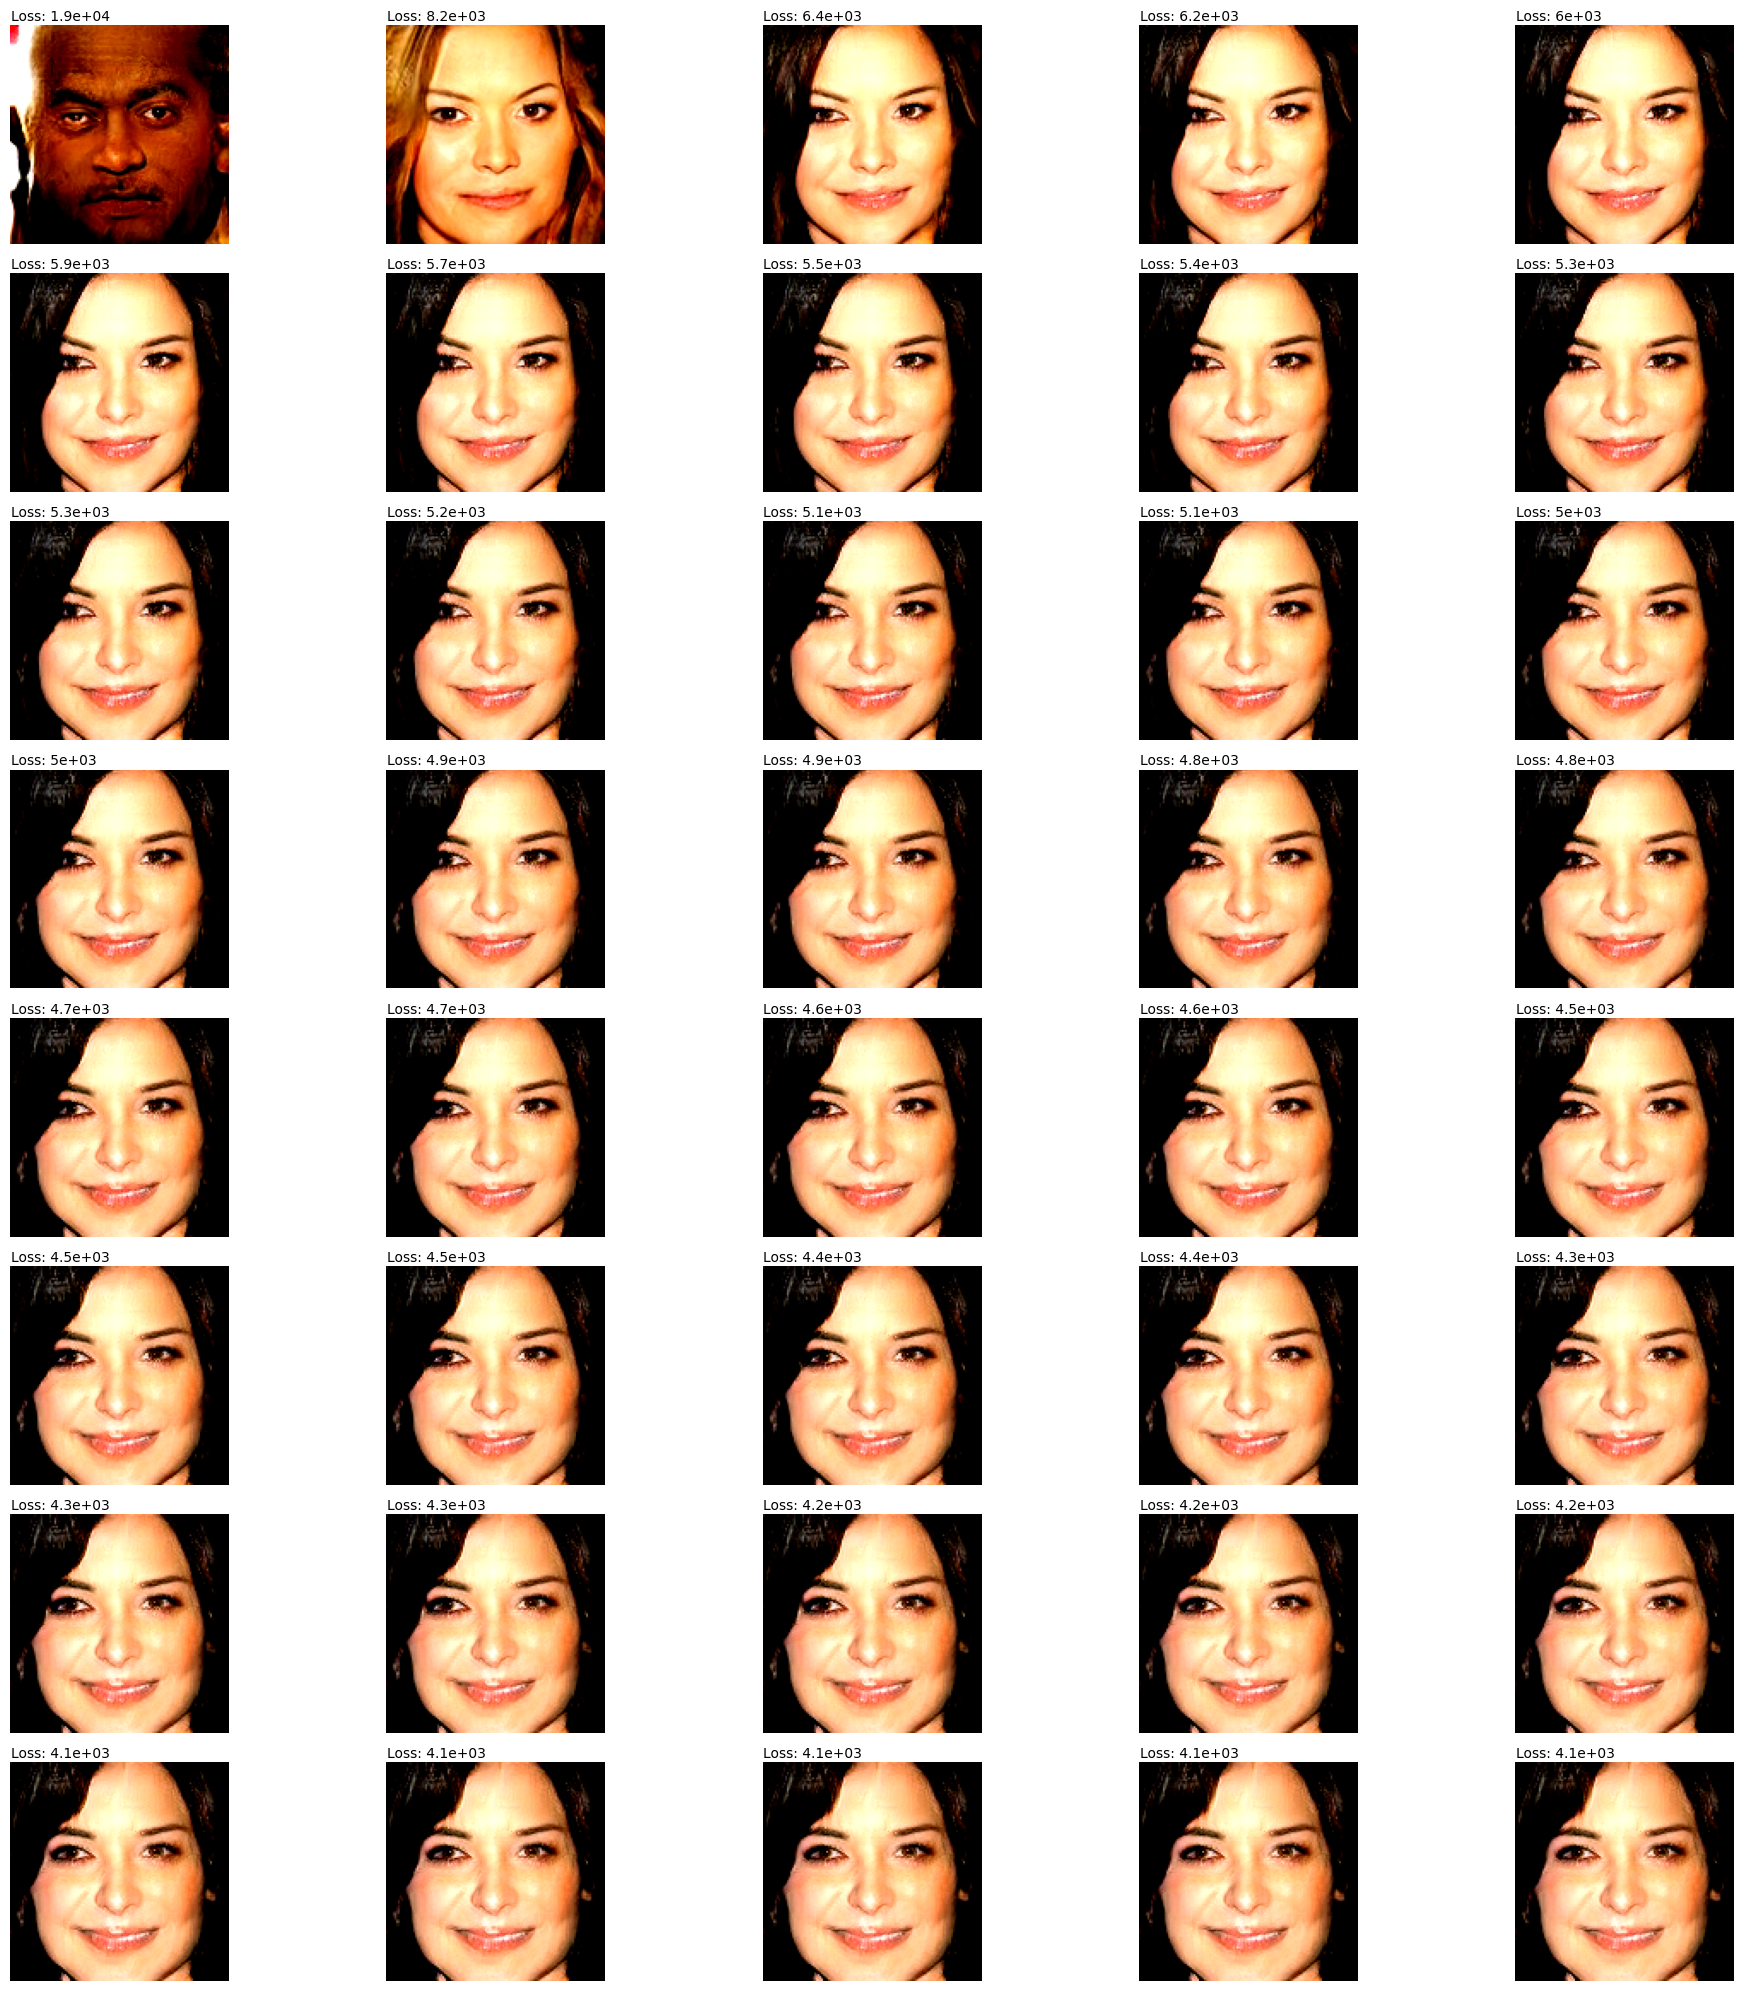

In [24]:
captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)